In [190]:
import torch
torch.manual_seed(0)
ONEHOT=False


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

### use dataloader & dataset API to load the Yu dataset

In [191]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

class YuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        if ONEHOT:
            self.Ys = F.one_hot(torch.tensor(Ys_list, dtype=torch.int64))
        else:
            self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


### proccess the Yu dataset

In [193]:
import csv

def proccess_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset is 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys
    
batch_size = 2048
datapath = '/home/skrhakv/deeplife/binding-prediction--deeplife-lab/data'


Xs_train, Ys_train = proccess_dataset(f'{datapath}/ADP_Training.txt', f'{datapath}/embeddings')

train_dataset = YuDataset(Xs_train, Ys_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Xs_test, Ys_test = proccess_dataset(f'{datapath}/ADP_Test.txt', f'{datapath}/embeddings')

test_dataset = YuDataset(Xs_test, Ys_test)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

### Define the sequence classifier

In [194]:
import torch.nn as nn

class YuClassifier(nn.Module):

   def __init__(self):
        super(YuClassifier, self).__init__()
        dropout = 0.3
        layer_width = 256
        self.linear1 = nn.Linear(2560, layer_width)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(layer_width, 2 * layer_width)
        self.dropout2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(2 * layer_width, layer_width)
        self.dropout3 = nn.Dropout(dropout)
        if ONEHOT:   
            self.linear4 = nn.Linear(layer_width, 2)
            self.normalization = nn.Softmax(dim = 1)

        else:
            self.linear4 = nn.Linear(layer_width, 1)
            self.normalization = nn.Sigmoid()

   def forward(self, x):
        x = self.linear1(x)
        x= F.relu(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.linear3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.linear4(x)

        # ensures that values add up to 1
        # x = self.normalization(x)
        return x

In [195]:
def evaluate(model, test_loader, error):
    correct = 0
    cur_loss = 0
    model.eval()
    predictions = None
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda().float()
        output = model(x)
        if not ONEHOT:
            y = y.unsqueeze(1)

        loss = error(output, y)
        # output = F.softmax(output, dim=1)
        cur_loss+=loss.item()
        if ONEHOT: 
            output = F.softmax(output, dim=1)
        else:
            output = F.sigmoid(output)
        predicted = torch.max(output,1)[1]
        target = torch.max(y,1)[1]

        if predictions == None:
            predictions = output
        else:
            predictions = torch.cat((predictions, output), 0)
        correct = correct + (predicted == target).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset), predictions.cpu()

def fit(model, train_loader, test_loader, error, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-1)

    model.train()
    losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            
            optimizer.zero_grad()
            output = model(X_batch)
            if not ONEHOT:
                y_batch = y_batch.unsqueeze(1)
            loss = error(output, y_batch)
            cur_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(cur_loss/len(train_loader.dataset))
        test_loss, _, _ = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{losses[-1]}, test loss:{test_losses[-1]}')

    return losses, test_losses

### Train imbalanced dataset
The dataset is heavily imbalanced, therefore we pass the `weight` argument for the loss function. But first, the weights need to be calculated using the `compute_class_weights(...)` function.

In [196]:
from sklearn.utils import class_weight

def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

model = YuClassifier()
model.cuda()
epochs = 30

_, labels = train_dataset[:]
if ONEHOT:
    labels = np.argmax(labels.numpy(), axis=1)
else:
    labels = labels.numpy()
class_weights = compute_class_weights(labels)
print('Computed weights: ', class_weights.numpy())
class_weights = class_weights.to(device)

# TODO: Add reduction='mean'?
if ONEHOT:
    error = nn.CrossEntropyLoss(weight=class_weights)
else:
    class_weights = torch.div(class_weights, class_weights[0])
    error = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
 
train_losses, test_losses = fit(model,train_dataloader, test_dataloader, error, epochs)   

Computed weights:  [ 0.51940954 13.380251  ]
Epoch : 0,  train loss:0.0005384788025947162, test loss:3.0978644007090664e-05
Epoch : 1,  train loss:0.00027912374553797754, test loss:2.6266756853337732e-05
Epoch : 2,  train loss:0.0002114997372367811, test loss:2.608462414328286e-05
Epoch : 3,  train loss:0.0001691508300473651, test loss:2.91982768394671e-05
Epoch : 4,  train loss:0.00014292490198407364, test loss:2.90993943421145e-05
Epoch : 5,  train loss:0.00012819010839866442, test loss:3.71079717648907e-05
Epoch : 6,  train loss:0.00010882488847233286, test loss:3.40767750444822e-05
Epoch : 7,  train loss:9.89444536927693e-05, test loss:3.494034318157398e-05
Epoch : 8,  train loss:8.43753279322934e-05, test loss:4.071629223827859e-05
Epoch : 9,  train loss:7.67785389251157e-05, test loss:4.593484014682573e-05
Epoch : 10,  train loss:7.130806309030024e-05, test loss:4.5220991343505174e-05
Epoch : 11,  train loss:6.328243913884159e-05, test loss:5.107945310719457e-05
Epoch : 12,  trai

In [198]:
_, accuracy, predictions = evaluate(model,train_dataloader, error)
_, labels = train_dataset[:]
predictions = predictions.cpu().detach().numpy()
if ONEHOT:
    actual_values = np.argmax(labels.numpy(), axis=1)
    preds = np.argmax(predictions, axis=1)
else: 
    actual_values = labels.numpy()
    preds = np.round(predictions[:,0])
true_positives = 0
for act, pre in zip(actual_values, preds):
    if act == 1 and pre == 1:
        true_positives = true_positives + 1
    print(act, pre)
print()
print('Number of true positives: ', true_positives)

0 0.0
0 0.0
0 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.0
0 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 1.0
0 0.0
0 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 1.0
1 0.0
1 1.0
1 0.0
0 0.0
0 0.0
1 1.0
0 1.0
0 1.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 1.0
0 0.0
0 0.0
0 0.0
1 0.0
1 0.0
0 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.0
1 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
0 0.

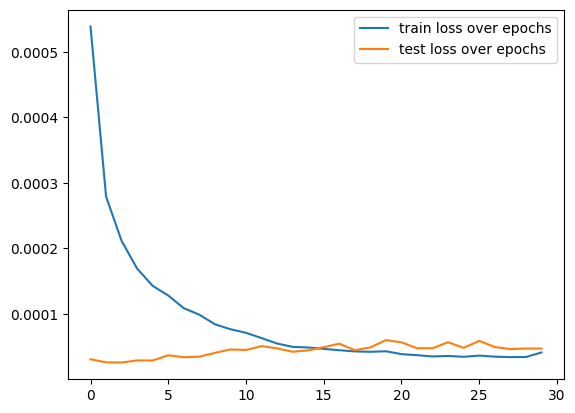

In [199]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

In [200]:
test_losses, accuracy, predictions = evaluate(model,test_dataloader, error)
_, labels = test_dataset[:]
predictions = predictions.cpu().detach().numpy()
print(test_losses)


4.725352589874057e-05


In [201]:
from sklearn import metrics  
def get_TPR(cf):
    FN = cf[0][1]
    TP = cf[1][1]
    return TP/(TP+FN)
    
def get_FPR(cf):
    FP = cf[1][0]
    TN = cf[0][0]
    return FP/(FP+TN)

print('Accuracy of our model: ', accuracy.cpu().numpy())
print()

print('Test dataset length: ', len(predictions))
print('Number of positive predictions: ', np.argmax(predictions, axis=1).sum())
if ONEHOT:
    positive_examples = np.argmax(labels.numpy(), axis=1).sum()
else:
    positive_examples = labels.numpy().sum()

print('Number of positive examples: ', positive_examples)
print()


if ONEHOT:
    actual_values = np.argmax(labels.numpy(), axis=1)
    preds = np.argmax(predictions, axis=1)
else: 
    actual_values = labels.numpy()
    preds = np.round(predictions[:,0])

cf = metrics.confusion_matrix(actual_values, preds)
print('true positive rate: ', get_TPR(cf))
print('false positive rate: ', get_FPR(cf))

# true_positives = 0
# for act, pre in zip(actual_values, preds):
#     if act == 1 and pre == 1:
#         true_positives = true_positives + 1
#     #print(act, pre)
print()
print('Number of true positives: ', cf[1][1])
print()


Accuracy of our model:  1.0

Test dataset length:  21013
Number of positive predictions:  0
Number of positive examples:  686

true positive rate:  0.0395010395010395
false positive rate:  0.03231759014512992

Number of true positives:  38



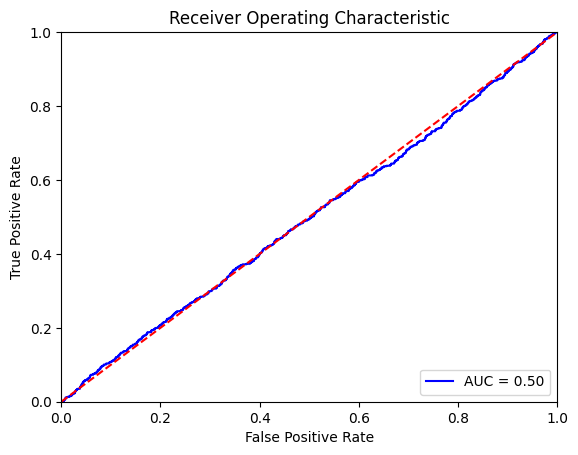

In [202]:
from sklearn import metrics

if ONEHOT: preds = predictions[:,1]
else: preds = predictions
fpr, tpr, thresholds = metrics.roc_curve(actual_values, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Homework: Part 1
Create embeddings based on sequences from the annotation files using a different model (ProtBERT, ProtT5, Ankh?)

In [ ]:
# import ankh
# protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
#   'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']
# 
# protein_sequences = [list(seq) for seq in protein_sequences]
# 
# 
# outputs = tokenizer.batch_encode_plus(protein_sequences, 
#                                 add_special_tokens=True, 
#                                 padding=True, 
#                                 is_split_into_words=True, 
#                                 return_tensors="pt")
# with torch.no_grad():
# embeddings = model(input_ids=outputs['input_ids'], attention_mask=outputs['attention_mask'])